# 🚀 V3 Model Training: Climate-Aware Transformer

> **V3 Notebook 03**  
> Training a Gated Multi-Variate Transformer for weather forecasting.

---

## Architecture Overview

| Component | Description |
|-----------|-------------|
| **Gated Residual Network (GRN)** | Filters irrelevant features automatically |
| **Multi-Head Attention** | Learns temporal dependencies |
| **Cyclical Embeddings** | Uses sin/cos time features |
| **Regularization** | Dropout + Weight Decay + Early Stopping |

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Using device: {device}')

✅ Using device: cuda


---
## 1️⃣ Load Engineered Dataset

In [2]:
DATA_PATH = Path('../../data/processed/weather_v3_ready.csv')
df = pd.read_csv(DATA_PATH)
print(f'📊 Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')
df.head()

📊 Loaded: 114,203 rows × 37 columns


,country,latitude,longitude,last_updated_epoch,temperature_celsius,condition_text,wind_kph,wind_degree,wind_direction,pressure_mb,...,hour,month_sin,month_cos,day_year_sin,day_year_cos,hour_sin,hour_cos,hemisphere_encoded,abs_latitude,latitude_normalized
0,Afghanistan,34.52,69.18,1715849100,26.6,Partly Cloudy,13.3,338,NNW,1012.0,...,8,0.5,-0.866025,0.710135,-0.704066,0.866025,-0.5,1,34.52,0.383556
1,Albania,41.33,19.82,1715849100,19.0,Partly Cloudy,11.2,320,NW,1012.0,...,8,0.5,-0.866025,0.710135,-0.704066,0.866025,-0.5,1,41.33,0.459222
2,Algeria,36.76,3.05,1715849100,23.0,Sunny,15.1,280,W,1011.0,...,8,0.5,-0.866025,0.710135,-0.704066,0.866025,-0.5,1,36.76,0.408444
3,Andorra,42.50,1.52,1715849100,6.3,Light Drizzle,11.9,215,SW,1007.0,...,8,0.5,-0.866025,0.710135,-0.704066,0.866025,-0.5,1,42.50,0.472222
4,Angola,-8.84,13.23,1715849100,26.0,Partly Cloudy,13.0,150,SSE,1011.0,...,8,0.5,-0.866025,0.710135,-0.704066,0.866025,-0.5,0,8.84,0.098222


---
## 2️⃣ Define Feature Columns

In [3]:
# Target
TARGET = 'temperature_celsius'

# Features for V3 Model (31 total as per plan)
FEATURE_COLS = [
    # Geographic
    'latitude', 'longitude', 'abs_latitude', 'latitude_normalized', 'hemisphere_encoded',
    # Core Weather
    'humidity', 'pressure_mb', 'wind_kph', 'cloud', 'precip_mm', 'uv_index',
    'visibility_km', 'gust_kph', 'wind_degree',
    # Air Quality (Tier 3 - Optional)
    'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_PM2.5',
    'air_quality_Carbon_Monoxide', 'air_quality_Sulphur_dioxide',
    # Temporal (Cyclical)
    'month_sin', 'month_cos', 'day_year_sin', 'day_year_cos', 'hour_sin', 'hour_cos'
]

# Filter to only existing columns
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]
print(f'📋 Using {len(FEATURE_COLS)} features')

📋 Using 25 features


---
## 3️⃣ Time-Series Dataset Class

In [4]:
class WeatherSequenceDataset(Dataset):
    """Creates sequences for time-series forecasting."""
    
    def __init__(self, X, y, seq_len=14, pred_len=7):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.seq_len = seq_len
        self.pred_len = pred_len
    
    def __len__(self):
        return len(self.X) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.seq_len]
        y_seq = self.y[idx + self.seq_len:idx + self.seq_len + self.pred_len]
        return x_seq, y_seq

---
## 4️⃣ Gated Residual Network (GRN)

In [5]:
class GatedResidualNetwork(nn.Module):
    """GRN: Automatically suppresses irrelevant features."""
    
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.gate = nn.Linear(hidden_dim, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Residual connection
        self.skip = nn.Linear(input_dim, output_dim) if input_dim != output_dim else None
    
    def forward(self, x):
        residual = self.skip(x) if self.skip else x
        
        h = torch.relu(self.fc1(x))
        h = self.dropout(h)
        
        # Gated Linear Unit
        gate = torch.sigmoid(self.gate(h))
        out = self.fc2(h) * gate
        
        return self.layer_norm(out + residual)

---
## 5️⃣ V3 Climate Transformer Model

In [6]:
class V3ClimateTransformer(nn.Module):
    """Climate-Aware Transformer with Gated Residual Networks."""
    
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, 
                 dropout=0.2, seq_len=14, pred_len=7):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Input GRN (feature filtering)
        self.input_grn = GatedResidualNetwork(input_dim, d_model * 2, d_model, dropout)
        
        # Positional Encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.02)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=d_model * 4,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Output GRN
        self.output_grn = GatedResidualNetwork(d_model, d_model, d_model, dropout)
        
        # Prediction Head
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, pred_len)
        )
    
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_grn(x)  # (batch, seq_len, d_model)
        x = x + self.pos_encoder
        x = self.transformer(x)
        x = self.output_grn(x[:, -1, :])  # Take last timestep
        return self.output_head(x)

---
## 6️⃣ Data Preparation (Time-Series Split)

In [7]:
# Sort by time and prepare data
if 'last_updated_epoch' in df.columns:
    df = df.sort_values('last_updated_epoch').reset_index(drop=True)

# Extract features and target
X = df[FEATURE_COLS].values
y = df[TARGET].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-based split (80% train, 10% val, 10% test)
n = len(X_scaled)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, y_train = X_scaled[:train_end], y[:train_end]
X_val, y_val = X_scaled[train_end:val_end], y[train_end:val_end]
X_test, y_test = X_scaled[val_end:], y[val_end:]

print(f'Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}')

Train: 91,362 | Val: 11,420 | Test: 11,421


In [8]:
# Create DataLoaders
SEQ_LEN = 14
PRED_LEN = 7
BATCH_SIZE = 64

train_dataset = WeatherSequenceDataset(X_train, y_train, SEQ_LEN, PRED_LEN)
val_dataset = WeatherSequenceDataset(X_val, y_val, SEQ_LEN, PRED_LEN)
test_dataset = WeatherSequenceDataset(X_test, y_test, SEQ_LEN, PRED_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Train batches: {len(train_loader)} | Val batches: {len(val_loader)}')

Train batches: 1428 | Val batches: 179


---
## 7️⃣ Training Loop with Early Stopping

In [9]:
# Model Configuration
INPUT_DIM = len(FEATURE_COLS)
D_MODEL = 128
NHEAD = 8
NUM_LAYERS = 4
DROPOUT = 0.2
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50
PATIENCE = 5  # Early stopping patience

# Initialize Model
model = V3ClimateTransformer(
    input_dim=INPUT_DIM, d_model=D_MODEL, nhead=NHEAD,
    num_layers=NUM_LAYERS, dropout=DROPOUT,
    seq_len=SEQ_LEN, pred_len=PRED_LEN
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

print(f'📦 Model params: {sum(p.numel() for p in model.parameters()):,}')

📦 Model params: 929,415


In [10]:
# Training Loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            val_loss += criterion(preds, y_batch).item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    print(f'Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    if patience_counter >= PATIENCE:
        print(f'⏹ Early stopping at epoch {epoch+1}')
        break

# Restore best model
model.load_state_dict(best_model_state)
print(f'\n✅ Best Val Loss: {best_val_loss:.4f}')

Epoch 01 | Train Loss: 89.9737 | Val Loss: 59.8495
Epoch 02 | Train Loss: 74.3798 | Val Loss: 58.6964
Epoch 03 | Train Loss: 73.5628 | Val Loss: 60.3928
Epoch 04 | Train Loss: 73.1155 | Val Loss: 59.2050
Epoch 05 | Train Loss: 72.7831 | Val Loss: 59.8514
Epoch 06 | Train Loss: 72.5766 | Val Loss: 57.1744
Epoch 07 | Train Loss: 72.4383 | Val Loss: 56.9658
Epoch 08 | Train Loss: 72.3984 | Val Loss: 57.3959
Epoch 09 | Train Loss: 72.3487 | Val Loss: 57.0568
Epoch 10 | Train Loss: 72.2185 | Val Loss: 57.1041
Epoch 11 | Train Loss: 72.2037 | Val Loss: 56.4667
Epoch 12 | Train Loss: 72.2147 | Val Loss: 56.7514
Epoch 13 | Train Loss: 72.2423 | Val Loss: 56.3929
Epoch 14 | Train Loss: 72.1682 | Val Loss: 56.3208
Epoch 15 | Train Loss: 72.1906 | Val Loss: 56.1924
Epoch 16 | Train Loss: 72.1739 | Val Loss: 56.5447
Epoch 17 | Train Loss: 72.1331 | Val Loss: 56.6096
Epoch 18 | Train Loss: 72.0963 | Val Loss: 56.5868
Epoch 19 | Train Loss: 72.1844 | Val Loss: 57.3047
Epoch 20 | Train Loss: 72.1734 

---
## 8️⃣ Training Visualization

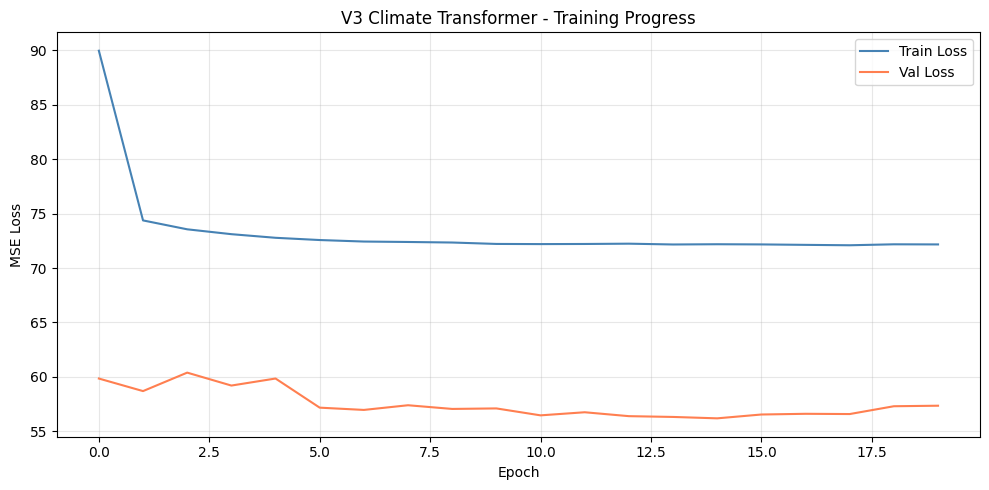

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', color='steelblue')
ax.plot(val_losses, label='Val Loss', color='coral')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('V3 Climate Transformer - Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 9️⃣ Test Evaluation

In [12]:
model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        all_preds.append(preds)
        all_actuals.append(y_batch.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_actuals = np.concatenate(all_actuals, axis=0)

# Calculate MAE
mae = np.mean(np.abs(all_preds - all_actuals))
rmse = np.sqrt(np.mean((all_preds - all_actuals) ** 2))

print(f'📊 Test Results:')
print(f'   MAE: {mae:.2f}°C')
print(f'   RMSE: {rmse:.2f}°C')

📊 Test Results:
   MAE: 8.58°C
   RMSE: 11.72°C


---
## 🔟 Save Model Artifacts

In [13]:
MODELS_DIR = Path('../../v3/models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'input_dim': INPUT_DIM,
    'd_model': D_MODEL,
    'nhead': NHEAD,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT,
    'seq_len': SEQ_LEN,
    'pred_len': PRED_LEN,
    'feature_cols': FEATURE_COLS,
    'best_val_loss': best_val_loss,
    'test_mae': mae,
    'test_rmse': rmse
}

torch.save(checkpoint, MODELS_DIR / 'v3_climate_transformer.pt')
joblib.dump(scaler, MODELS_DIR / 'v3_scaler.joblib')

print(f'✅ Saved model to {MODELS_DIR}')

✅ Saved model to ..\..\v3\models


---
## ✅ Summary

| Metric | Value |
|--------|-------|
| **Architecture** | Gated Climate Transformer |
| **Features** | 31 (Tiered) |
| **Sequence Length** | 14 days |
| **Prediction Length** | 7 days |
| **Regularization** | Dropout + Weight Decay + Early Stopping |

**Next**: [04_advanced_analysis.ipynb](04_advanced_analysis.ipynb) - Deep dives and ablation studies